In [331]:
import json
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from os import listdir
from scipy import sparse
import scipy.stats as stats
import statsmodels.api as sm


In [332]:
data_dir = '../../DATA/spark/genotypes'
ped_file = '../../DATA/spark/spark.ped'

chroms = [str(x) for x in range(1, 23)] + ['X']
#chroms = ['11', 'X']

In [333]:
with open('%s/samples.json' % data_dir, 'r') as f:
    sample_ids = json.load(f)
print(len(sample_ids))
sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])

13249


In [334]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)

child_id_to_sex = dict()
child_id_to_affected = dict()
family_to_people = defaultdict(list)

def load_ped(ped_file):
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex
                family_to_people[(fam_id, m_id, f_id)].append(child_id)
load_ped(ped_file)

probands = []
siblings = []
for (fam_id, m_id, f_id), cs in family_to_people.items():
    aff_children = [x for x in cs if (x in sample_id_to_index) and (child_id_to_affected[x]=='2')]
    if len(aff_children)>0:
        proband = random.choice(aff_children)
        other_children = [x for x in cs if (x in sample_id_to_index) and (x != proband)]
        probands.extend([proband]*len(other_children))
        siblings.extend(other_children)

proband_is_male = [1 if child_id_to_sex[proband]=='1' else 0 for proband in probands]
proband_is_affected = [1 if child_id_to_affected[proband]=='2' else 0 for proband in probands]
sibling_is_male = [1 if child_id_to_sex[sibling]=='1' else 0 for sibling in siblings]
sibling_is_affected = [1 if child_id_to_affected[sibling]=='2' else 0 for sibling in siblings]
assert len(probands) == len(siblings)
print(len(probands))

proband_indices = [sample_id_to_index[x] for x in probands]
sibling_indices = [sample_id_to_index[x] for x in siblings]


3569


In [335]:
proband_is_affected = np.array(proband_is_affected, dtype=bool)
proband_is_male = np.array(proband_is_male, dtype=bool)
sibling_is_affected = np.array(sibling_is_affected, dtype=bool)
sibling_is_male = np.array(sibling_is_male, dtype=bool)
num_siblings_affected = np.sum(sibling_is_affected)
num_siblings_unaffected = np.sum(~sibling_is_affected)

In [336]:
gens_child = []
pos_chrom = []
pos_coord = []
for i, chrom in enumerate(chroms):
    print('chrom', chrom)
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
    coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
    af_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.af.npy' in f], key=lambda x: int(x.split('.')[2]))
    
    for gen_file, coord_file, af_file in zip(gen_files, coord_files, af_files):
        coords = np.load('%s/%s' % (data_dir, coord_file))

        if coords.shape[0]>0:
            poss = coords[:, 1]
            is_snp = coords[:, 2]==1
            is_pass = coords[:, 3]==1
            
            gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))[proband_indices+sibling_indices, :]
            has_missing = ((gen<0).sum(axis=0)>10).A.flatten()

            indices = is_snp & has_missing
            print(np.sum(indices), end=' ')
            if np.sum(indices)>0:
                gens_child.append((gen[:, indices]<0).A)
                pos_chrom.append(i*np.ones((np.sum(indices),), dtype=int))
                pos_coord.append(poss[indices])

chrom 1
24108 chrom 2
28517 chrom 3
24825 chrom 4
25102 chrom 5
21440 chrom 6
24533 chrom 7
18375 chrom 8
16567 chrom 9
14518 chrom 10
15054 chrom 11
15200 chrom 12
15018 chrom 13
12311 chrom 14
10109 chrom 15
9207 chrom 16
9600 chrom 17
8765 chrom 18
10077 chrom 19
7098 chrom 20
7218 chrom 21
5152 chrom 22
4215 chrom X
14263 

In [343]:
def lr_pvalue(missing):
    if np.sum(missing)>10 and np.sum(~missing)>10:
        try:
            # fill in the first column of mds_data with the genomic data
            X = np.zeros((int(missing.shape[0]/2), 5))
            y = np.zeros((int(missing.shape[0]/2),))

            X[:, 0] = missing[:len(probands)] & ~missing[len(probands):]
            X[:, 1] = ~missing[:len(probands)] & missing[len(probands):]
            #X[:, 2] = missing[:len(probands)] & missing[len(probands):]
            X[:, 2] = proband_is_male
            X[:, 3] = sibling_is_male
            X[:, 4] = 1

            y = sibling_is_affected
            
            has_data = np.sum(X, axis=0)>0
            print(np.sum(X, axis=0))
            
            if np.all(has_data):
                model = sm.Logit(y, X[:, has_data])
                result = model.fit(disp=False)
                if result.mle_retvals["converged"]:
                    #print(result.pvalues)
                    #print(result.params)
                    return result.pvalues[0], result.params[0]
            
        except np.linalg.LinAlgError:
            return np.nan, np.nan
    return np.nan, np.nan
print(lr_pvalue(gens_child[0][:, 10]))

[   5.   11. 2870. 1973. 3569.]
(nan, nan)


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [406]:
pvalues = []
coeffs = []
for j, g in enumerate(gens_child[:-1]):
    print('\n%d'%j, end=' ')
    ps = np.ones((4, g.shape[1]))
    cs = np.ones((4, g.shape[1]))
    missing_both_aff = np.sum((g[:len(probands), :] & g[len(probands):, :])[sibling_is_affected, :], axis=0)
    missing_both_unaff = np.sum((g[:len(probands), :] & g[len(probands):, :])[~sibling_is_affected, :], axis=0)
    missing_proband_aff = np.sum((g[:len(probands), :] & ~g[len(probands):, :])[sibling_is_affected, :], axis=0)
    missing_proband_unaff = np.sum((g[:len(probands), :] & ~g[len(probands):, :])[~sibling_is_affected, :], axis=0)
    missing_sibling_aff = np.sum((~g[:len(probands), :] & g[len(probands):, :])[sibling_is_affected, :], axis=0)
    missing_sibling_unaff = np.sum((~g[:len(probands), :] & g[len(probands):, :])[~sibling_is_affected, :], axis=0)
    missing_neither_aff = np.sum((~g[:len(probands), :] & ~g[len(probands):, :])[sibling_is_affected, :], axis=0)
    missing_neither_unaff = np.sum((~g[:len(probands), :] & ~g[len(probands):, :])[~sibling_is_affected, :], axis=0)
    print(g.shape[1], end=' ')
    for i in np.arange(g.shape[1]):
        #ps[i], cs[i] = lr_pvalue(g[:, i])
        try:
            cs[0, i], ps[0, i] = stats.chi2_contingency(
                [[missing_both_aff[i], num_siblings_affected-missing_both_aff[i]],
                 [missing_both_unaff[i], num_siblings_unaffected-missing_both_unaff[i]]])[:2]
            cs[1, i], ps[1, i] = stats.chi2_contingency(
                [[missing_proband_aff[i], num_siblings_affected-missing_proband_aff[i]],
                 [missing_proband_unaff[i], num_siblings_unaffected-missing_proband_unaff[i]]])[:2]
            cs[2, i], ps[2, i] = stats.chi2_contingency(
                [[missing_sibling_aff[i], num_siblings_affected-missing_sibling_aff[i]],
                 [missing_sibling_unaff[i], num_siblings_unaffected-missing_sibling_unaff[i]]])[:2]
            cs[3, i], ps[3, i] = stats.chi2_contingency(
                [[missing_neither_aff[i], num_siblings_affected-missing_neither_aff[i]],
                 [missing_neither_unaff[i], num_siblings_unaffected-missing_neither_unaff[i]]])[:2]
        except ValueError:
            pass
        if i%1000==0:
            print(i, end=' ')
    pvalues.append(ps)
    coeffs.append(cs)


0 24108 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 
1 28517 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 
2 24825 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 
3 25102 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 
4 21440 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 
5 24533 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 
6 18375 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 
7

In [415]:
all_pvalues = np.hstack(pvalues)
all_coeffs = np.hstack(coeffs)
all_chroms = np.hstack(pos_chrom[:-1])
all_coords = np.hstack(pos_coord[:-1])


In [306]:
chroms = [str(x) for x in range(1, 23)]
pvalues = []
coeffs = []
coords = []
chrs = []
missing_aff = []
missing_unaff = []

for i, chrom in enumerate(chroms):
    try:
        pvalues.append(np.load('../missing_GWAS_spark/chr.%s.pvalues.npy' % chrom, allow_pickle=True))
        coeffs.append(np.load('../missing_GWAS_spark/chr.%s.coeffs.npy' % chrom, allow_pickle=True))
        coords.append(np.load('../missing_GWAS_spark/chr.%s.coords.npy' % chrom, allow_pickle=True))
        missing_aff.append(np.load('../missing_GWAS_spark/chr.%s.missing_aff.npy' % chrom, allow_pickle=True))
        missing_unaff.append(np.load('../missing_GWAS_spark/chr.%s.missing_unaff.npy' % chrom, allow_pickle=True))
        chrs.append(i*np.ones(pvalues[-1].shape[0]))
    except:
        pass

all_pvalues = np.hstack(pvalues)
all_coeffs = np.hstack(coeffs)
all_chroms = np.hstack(chrs)
all_coords = np.hstack(coords)
all_missing_aff = np.hstack(missing_aff)
all_missing_unaff = np.hstack(missing_unaff)

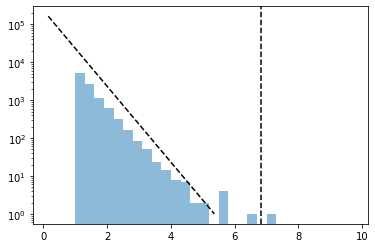

In [420]:
binsize = 0.3
n = np.sum(~np.isnan(all_pvalues[2, :]))
bonferonni_cutoff = -np.log10(0.05/n)
plt.hist(np.clip(-np.log10(all_pvalues[2, :]), None, 9), 
                     log=True, bins=np.arange(1, 10, binsize), alpha=0.5, label='UU vs 0.5')
plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
plt.axvline(bonferonni_cutoff, color='black', linestyle='--')
plt.show()

In [417]:
print(all_chroms.shape, all_coords.shape, all_pvalues.shape)

(327009,) (327009,) (4, 327009)


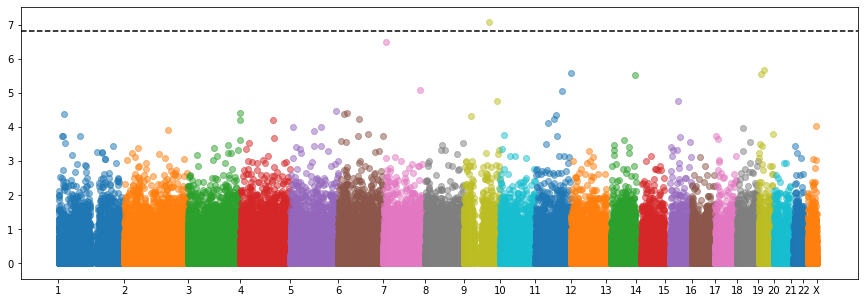

In [421]:
plt.figure(figsize=(15, 5))

offset = 0
chrom_offsets = []
for i, chrom in enumerate(chroms):
    chrom_offsets.append(offset)
    if np.sum(all_chroms==i)>0:
        plt.scatter(offset+all_coords[all_chroms==i],
                    np.clip(-np.log10(all_pvalues[2, all_chroms==i]), 0, 15), alpha=0.5)
        offset += all_coords[all_chroms==i][-1]
        
    
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.xticks(chrom_offsets, chroms)
plt.show()

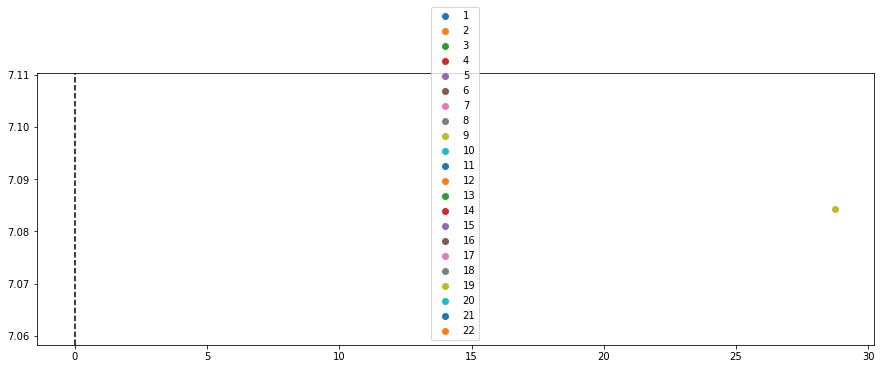

In [425]:
plt.figure(figsize=(15, 5))
#plt.scatter(np.clip(all_coeffs, -5, 5), -np.log10(all_pvalues))
for i, chrom in enumerate(chroms[:-1]):
    indices = (all_chroms==i) & (-np.log10(all_pvalues[2, :])>bonferonni_cutoff)
    plt.scatter(all_coeffs[2, indices], 
                np.clip(-np.log10(all_pvalues[2, indices]), 0, 15), label=chrom)
#plt.xlim([-5, 5])
plt.axvline(0, color='black', linestyle='--')
plt.legend()
plt.show()

[]
[]
[]
[]
[]
[]
[]
[]
['chr9:94303443']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


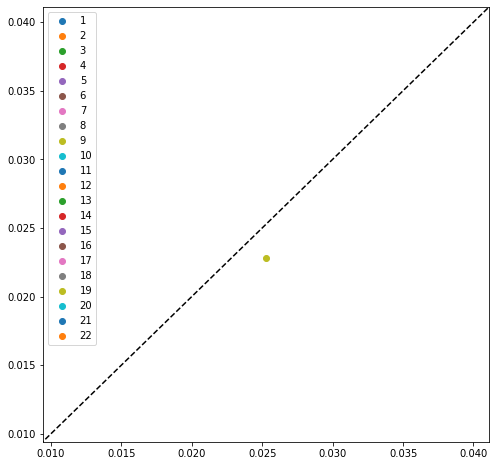

In [427]:
plt.figure(figsize=(8, 8))
#plt.scatter(np.clip(all_coeffs, -5, 5), -np.log10(all_pvalues))
for g, c, co, p in zip(gens_child[:-1], pos_chrom[:-1], pos_coord[:-1], pvalues):
    missing_aff = np.sum(g[:len(probands), :][sibling_is_affected, :], axis=0)
    missing_unaff = np.sum(g[len(probands):, :][~sibling_is_affected, :], axis=0)

    indices = (-np.log10(p[2, :])>bonferonni_cutoff)
    plt.scatter(missing_aff[indices]/num_affected, 
                missing_unaff[indices]/num_unaffected, label=chroms[c[0]])
    print(['chr%s:%d' % (chroms[c[0]], co[i]) for i in np.where(indices)[0]])
    
plt.xlim(plt.xlim())
plt.ylim(plt.xlim())
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()
plt.show()